In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
path = "../data/Formula 1 World Championship (1950 - 2023) Kaggle"

# Load data
df_circuits = pd.read_csv(path + "/circuits.csv")
df_constructor_results = pd.read_csv(path + "/constructor_results.csv")
df_constructor_standings = pd.read_csv(path + "/constructor_standings.csv")
df_constructors = pd.read_csv(path + "/constructors.csv")
df_driver_standings = pd.read_csv(path + "/driver_standings.csv")
df_drivers = pd.read_csv(path + "/drivers.csv")
df_lap_times = pd.read_csv(path + "/lap_times.csv")
df_pit_stops = pd.read_csv(path + "/pit_stops.csv")
df_qualifying = pd.read_csv(path + "/qualifying.csv")
df_races = pd.read_csv(path + "/races.csv")
df_results = pd.read_csv(path + "/results.csv")
df_seasons = pd.read_csv(path + "/seasons.csv")
df_sprint_results = pd.read_csv(path + "/sprint_results.csv")
df_status = pd.read_csv(path + "/status.csv")

### Limit data to last X seasons

In [4]:
min_year = 2022

In [5]:
# Limit df_races to rows where year is equal or greater to 2022
print("Len before filter:", len(df_races))
df_races = df_races[df_races['year'] >= min_year]
print("Len after filter:", len(df_races))

Len before filter: 1101
Len after filter: 44


In [6]:
# Now we can filter all other data to only keep the races from 2022 and 2023
print("> df_constructor_results")
print("Len before filter:", len(df_constructor_results))
df_constructor_results = df_constructor_results[df_constructor_results['raceId'].isin(df_races['raceId'])]
print("Len after filter:", len(df_constructor_results))

print("\n> df_constructor_standings")
print("Len before filter:", len(df_constructor_standings))
df_constructor_standings = df_constructor_standings[df_constructor_standings['raceId'].isin(df_races['raceId'])]
print("Len after filter:", len(df_constructor_standings))

print("\n> df_driver_standings")
print("Len before filter:", len(df_driver_standings))
df_driver_standings = df_driver_standings[df_driver_standings['raceId'].isin(df_races['raceId'])]
print("Len after filter:", len(df_driver_standings))

print("\n> df_lap_times")
print("Len before filter:", len(df_lap_times))
df_lap_times = df_lap_times[df_lap_times['raceId'].isin(df_races['raceId'])]
print("Len after filter:", len(df_lap_times))

print("\n> df_pit_stops")
print("Len before filter:", len(df_pit_stops))
df_pit_stops = df_pit_stops[df_pit_stops['raceId'].isin(df_races['raceId'])]
print("Len after filter:", len(df_pit_stops))

print("\n> df_qualifying")
print("Len before filter:", len(df_qualifying))
df_qualifying = df_qualifying[df_qualifying['raceId'].isin(df_races['raceId'])]
print("Len after filter:", len(df_qualifying))

print("\n> df_results")
print("Len before filter:", len(df_results))
df_results = df_results[df_results['raceId'].isin(df_races['raceId'])]
print("Len after filter:", len(df_results))  

print("\n> df_sprint_results")
print("Len before filter:", len(df_sprint_results))
df_sprint_results = df_sprint_results[df_sprint_results['raceId'].isin(df_races['raceId'])]
print("Len after filter:", len(df_sprint_results))

> df_constructor_results
Len before filter: 12290
Len after filter: 340

> df_constructor_standings
Len before filter: 13051
Len after filter: 340

> df_driver_standings
Len before filter: 34124
Len after filter: 709

> df_lap_times
Len before filter: 551742
Len after filter: 37150

> df_pit_stops
Len before filter: 10089
Len after filter: 1260

> df_qualifying
Len before filter: 9815
Len after filter: 680

> df_results
Len before filter: 26080
Len after filter: 680

> df_sprint_results
Len before filter: 180
Len after filter: 120


---

# First model to predict the average finish position for the next race

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Sort the results to ensure chronological order
df_results_sorted = df_results.sort_values(by=['driverId', 'raceId'])

# Number of races to consider and decay rate
X = 3  # Number of recent races to consider
decay_rate = 0.9  # Decay rate to apply to each previous race

# Prepare the dataset
def prepare_dataset(df, X, decay_rate):
    weighted_positions = []

    # Iterate over each row in the dataframe
    for index, row in df.iterrows():
        driver_id = row['driverId']
        race_id = row['raceId']

        # Get the last X races for the driver before the current race
        previous_races = df[(df['driverId'] == driver_id) & (df['raceId'] < race_id)].tail(X)

        # Apply decay to each position
        weights = [decay_rate ** i for i in range(len(previous_races))]
        weighted_position = np.average(previous_races['positionOrder'], weights=weights) if not previous_races.empty else np.nan

        weighted_positions.append(weighted_position)

    df['weighted_position'] = weighted_positions
    return df

In [8]:
# Apply the function to prepare the dataset
df_prepared = prepare_dataset(df_results_sorted, X, decay_rate)

# Drop rows with NaN values (races without enough historical data)
df_prepared = df_prepared.dropna()

# Display the prepared dataset
df_prepared.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,weighted_position
25429,25435,1075,1,131,44,15,10,10,10,1.0,50,+1:13.948,5133241,47,8,1:32.997,239.001,1,3.000000
25443,25449,1076,1,131,44,5,4,4,4,12.0,58,+28.543,5295091,51,7,1:21.886,232.039,1,6.315789
25472,25478,1077,1,131,44,14,13,13,13,0.0,62,\N,\N,50,13,1:21.419,217.054,11,5.623616
25485,25491,1078,1,131,44,6,6,6,6,8.0,57,+21.368,5685626,55,7,1:32.941,209.629,1,8.904059
25504,25510,1079,1,131,44,6,5,5,5,10.0,66,+54.534,5895009,51,2,1:24.253,199.755,1,7.586716


### Step 2: Create Features and Labels

In [9]:
# The feature is the weighted_position, and the label is the actual positionOrder of the next race
features = df_prepared[['weighted_position']]
labels = df_prepared['positionOrder']

### Step 3: Train/Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

### Step 4: Train the Model

In [11]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

### Step 5: Evaluate the Model


In [12]:
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 21.89574879412959


In [13]:
# find the driverId for Lewis Hamilton by searching the rows where the driverref contains 'ham'
driver = df_drivers[df_drivers['driverRef'].str.contains('lec', case=False)]
driver

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
276,277,leclere,\N,\N,Michel,Leclère,1946-03-18,French,http://en.wikipedia.org/wiki/Michel_Lecl%C3%A8re
842,844,leclerc,16,LEC,Charles,Leclerc,1997-10-16,Monegasque,http://en.wikipedia.org/wiki/Charles_Leclerc


In [14]:
def predict_next_race_position(driver_id, model, df_prepared, X, decay_rate):
    # Filter the driver's results and sort by raceId
    driver_results = df_prepared[df_prepared['driverId'] == driver_id].sort_values(by='raceId')

    # Check if there are at least X races to consider
    if len(driver_results) >= X:
        # Prepare the input for prediction (last X races)
        last_X_races = driver_results.tail(X)
        weights = [decay_rate ** i for i in range(X)]
        weighted_position = np.average(last_X_races['positionOrder'], weights=weights)

        # Predict the next race position
        predicted_position = model.predict([[weighted_position]])[0]
        return predicted_position
    else:
        print("Not enough races for prediction.")
        return None

In [15]:
# Example: Predict the next race position for a specific driver
driver_id_example = 844 
predicted_position = predict_next_race_position(driver_id_example, model, df_prepared, X, decay_rate)
print(f"Predicted position for driver {driver_id_example}: {predicted_position}")

Predicted position for driver 844: 8.022301184262092


/Users/louisar/Documents/DevVsCode/Efrei/F1-ML-Prediction/formulaOneEnv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


# Saving the model

In [16]:
# Now lets save this model to a file
import joblib

# Save the model to a file
joblib.dump(model, '../Models/model.pkl')

['../Models/model.pkl']

# Using the model

In [1]:
import joblib

# Load the model 
model = joblib.load('../Models/model.pkl')

In [4]:
import pandas as pd

path = "../data/Formula 1 World Championship (1950 - 2023) Kaggle"
df_results = pd.read_csv(path + "/results.csv")
df_races = pd.read_csv(path + "/races.csv")

# Limit df to races after 2021
df_races = df_races[df_races['year'] >= 2022]

df_results = df_results[df_results['raceId'].isin(df_races['raceId'])]

df_results.head(5)

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
25400,25406,1074,844,6,16,1,1,1,1,26.0,57,1:37:33.584,5853584,51,1,1:34.570,206.018,1
25401,25407,1074,832,6,55,3,2,2,2,18.0,57,+5.598,5859182,52,3,1:35.740,203.501,1
25402,25408,1074,1,131,44,5,3,3,3,15.0,57,+9.675,5863259,53,5,1:36.228,202.469,1
25403,25409,1074,847,131,63,9,4,4,4,12.0,57,+11.211,5864795,56,6,1:36.302,202.313,1
25404,25410,1074,825,210,20,7,5,5,5,10.0,57,+14.754,5868338,53,8,1:36.623,201.641,1


In [5]:
# Prepare dataset

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

df_results_sorted = df_results.sort_values(by=['driverId', 'raceId'])

X = 3  # Number of recent races to consider
decay_rate = 0.9  # Decay rate to apply to each previous race

# Prepare the dataset
def prepare_dataset(df, X, decay_rate):
    weighted_positions = []

    # Iterate over each row in the dataframe
    for index, row in df.iterrows():
        driver_id = row['driverId']
        race_id = row['raceId']

        # Get the last X races for the driver before the current race
        previous_races = df[(df['driverId'] == driver_id) & (df['raceId'] < race_id)].tail(X)

        # Apply decay to each position
        weights = [decay_rate ** i for i in range(len(previous_races))]
        weighted_position = np.average(previous_races['positionOrder'], weights=weights) if not previous_races.empty else np.nan

        weighted_positions.append(weighted_position)

    df['weighted_position'] = weighted_positions
    return df


In [6]:
# Apply the function to prepare the dataset
df_prepared = prepare_dataset(df_results_sorted, X, decay_rate)

# Drop rows
df_prepared = df_prepared.dropna()

# Display the prepared dataset
df_prepared.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,weighted_position
25429,25435,1075,1,131,44,15,10,10,10,1.0,50,+1:13.948,5133241,47,8,1:32.997,239.001,1,3.000000
25443,25449,1076,1,131,44,5,4,4,4,12.0,58,+28.543,5295091,51,7,1:21.886,232.039,1,6.315789
25472,25478,1077,1,131,44,14,13,13,13,0.0,62,\N,\N,50,13,1:21.419,217.054,11,5.623616
25485,25491,1078,1,131,44,6,6,6,6,8.0,57,+21.368,5685626,55,7,1:32.941,209.629,1,8.904059
25504,25510,1079,1,131,44,6,5,5,5,10.0,66,+54.534,5895009,51,2,1:24.253,199.755,1,7.586716


In [8]:
def predict_next_race_position(driver_id, model, df_prepared, X, decay_rate):
    # Filter the driver's results and sort by raceId
    driver_results = df_prepared[df_prepared['driverId'] == driver_id].sort_values(by='raceId')

    # Check if there are at least X races to consider
    if len(driver_results) >= X:
        # Prepare the input for prediction (last X races)
        last_X_races = driver_results.tail(X)
        weights = [decay_rate ** i for i in range(X)]
        weighted_position = np.average(last_X_races['positionOrder'], weights=weights)

        # Predict the next race position
        predicted_position = model.predict([[weighted_position]])[0]
        return predicted_position
    else:
        print("Not enough races for prediction.")
        return None

In [9]:
driver_id_example = 844 # Leclerc
predicted_position = predict_next_race_position(driver_id_example, model, df_prepared, X, decay_rate)
print(f"Predicted position for driver {driver_id_example}: {predicted_position}")

Predicted position for driver 844: 8.022301184262092


/Users/louisar/Documents/DevVsCode/Efrei/F1-ML-Prediction/formulaOneEnv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


---
# Another model (more complex)

Test Log Loss: 2.9025
Test Accuracy: 0.1007


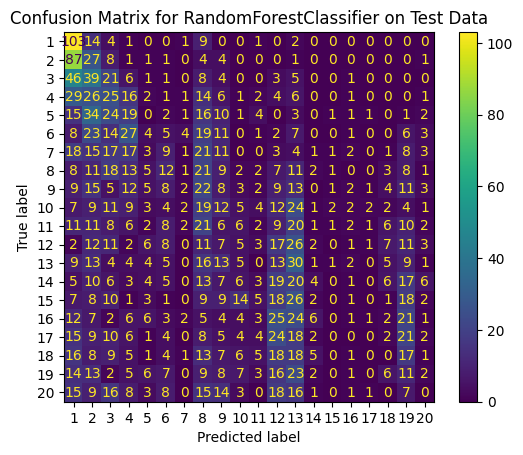

['/Users/louisar/Documents/DevVsCode/Efrei/F1-ML-Prediction/notebooks/RandomForestClassifier_model.joblib']

In [50]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib

# Data loading
folder_path = '/Users/louisar/Documents/DevVsCode/Efrei/F1-ML-Prediction/data/Formula 1 World Championship (1950 - 2023) Kaggle'
constructors_df = pd.read_csv(f'{folder_path}/constructors.csv')
drivers_df = pd.read_csv(f'{folder_path}/drivers.csv')
races_df = pd.read_csv(f'{folder_path}/races.csv')
results_df = pd.read_csv(f'{folder_path}/results.csv')

# Preprocessing
races_df = races_df[["raceId", "year", "round", "circuitId"]].copy()
races_df = races_df.sort_values(by=['year', 'round'])
races_df = races_df[races_df["year"] >= 1982]
results_df = results_df[['raceId', 'driverId', 'constructorId', 'grid', 'positionOrder']].copy()
df = pd.merge(races_df, results_df, on='raceId')

# Feature Engineering
df['Top 3 Finish'] = df['positionOrder'].le(3).astype(int)

# More preprocessing
df_final = df.drop(labels=["raceId"], axis=1).dropna()
df_final = df_final[df_final['year'] != 1982]
df_final_keepPositionOrder = df_final.copy()
df_final = df_final.drop(["positionOrder"], axis=1)

# One-hot encoding
df_final_encoded = pd.get_dummies(df_final, columns=['circuitId', 'driverId', 'constructorId'])
cols = [col for col in df_final_encoded.columns if col != 'Top 3 Finish']
df_final_encoded = df_final_encoded[cols + ['Top 3 Finish']]

# Preparing data for model
df_position = df_final_encoded.copy()
df_position.drop(["Top 3 Finish"], axis=1, inplace=True)
df_position['positionOrder'] = df_final_keepPositionOrder['positionOrder']

df_top20 = df_position[df_position['positionOrder'] <= 20]

# Splitting the data
train_df = df_top20[(df_top20["year"] >= 1983) & (df_top20["year"] <= 2008)]
val_df = df_top20[(df_top20["year"] >= 2009) & (df_top20["year"] <= 2016)]
test_df = df_top20[(df_top20["year"] >= 2017) & (df_top20["year"] <= 2023)]

X_train = train_df.drop('positionOrder', axis=1)
y_train = train_df['positionOrder']
X_val = val_df.drop('positionOrder', axis=1)
y_val = val_df['positionOrder']
X_test = test_df.drop('positionOrder', axis=1)
y_test = test_df['positionOrder']

# Model Training
rf_classifier = RandomForestClassifier(max_depth=10, n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Model Evaluation
pred_test = rf_classifier.predict(X_test)
probabilities_test = rf_classifier.predict_proba(X_test)
log_loss_test = log_loss(y_test, probabilities_test)
accuracy_test = accuracy_score(y_test, pred_test)
print(f"Test Log Loss: {log_loss_test:.4f}")
print(f"Test Accuracy: {accuracy_test:.4f}")

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, pred_test)
plt.title("Confusion Matrix for RandomForestClassifier on Test Data")
plt.show()

# Save the model
joblib.dump(rf_classifier, '/Users/louisar/Documents/DevVsCode/Efrei/F1-ML-Prediction/notebooks/RandomForestClassifier_model.joblib')

### Last try ...

In [2]:
df

,raceId,circuitId,driverId,constructorId,grid,positionOrder
0,900,1,3,131,3,1
1,900,1,825,1,4,2
2,900,1,18,1,10,3
3,900,1,4,6,5,4
4,900,1,822,3,15,5
...,...,...,...,...,...,...
4122,1119,80,858,3,6,16
4123,1119,80,822,51,7,17
4124,1119,80,852,213,20,18
4125,1119,80,807,210,13,19


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import joblib

# Load the datasets
folder_path = '../data/api_ergast/2024-02-06_12h16'  # Update this to your data folder path
races_df = pd.read_csv(f'{folder_path}/races.csv')
results_df = pd.read_csv(f'{folder_path}/results.csv')

# Preprocessing and feature selection
df = pd.merge(races_df[['raceId','circuitId']], results_df[['raceId', 'driverId', 'constructorId', 'grid', 'positionOrder']], on='raceId')
df = df.dropna()

# Assuming we are focusing on 'grid', 'constructorId', and the target 'positionOrder'
X = df[['grid', 'constructorId', 'driverId','circuitId']]
y = df['positionOrder']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
# Print the accuracy
print(f"Accuracy: {model.score(X_test, y_test)}")

# Save the model for future use
joblib.dump(model, 'random_forest_regressor_model.joblib')

RMSE: 4.407621422969241
Accuracy: 0.4342657579568834


['random_forest_regressor_model.joblib']

In [5]:
import pandas as pd
import joblib

# Load the trained model
model_path = 'random_forest_regressor_model.joblib'  # Update this path
model = joblib.load(model_path)

# Example new data for prediction
# Suppose you want to predict the finishing position for a driver starting from grid position 5 for constructor ID 1
new_data = {
    'grid': [1],  # Grid position
    'constructorId': [9],  # Constructor ID
    'driverId': [830],  # Driver ID
    'circuitId': [6]
}

# Convert the new data to a DataFrame
new_data_df = pd.DataFrame(new_data)

# Use the model to make predictions
predictions = model.predict(new_data_df)

# Print the predicted finishing position
print(f"Predicted Finishing Position: {predictions[0]}")

Predicted Finishing Position: 2.2300251379385245
